In [32]:
import pandas as pd 
import seaborn as sns 
from xgboost.sklearn import XGBClassifier
import numpy as np
import math
from matplotlib import pyplot as plt 

In [105]:
train1=pd.read_csv('train_avg_age.csv')
test1=pd.read_csv('test_avg_age.csv')
val1=pd.read_csv('val_avg_age.csv')

In [106]:
train2=pd.read_csv('train_knn_age.csv')
test2=pd.read_csv('test_knn_age.csv')
val2=pd.read_csv('val_knn_age.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


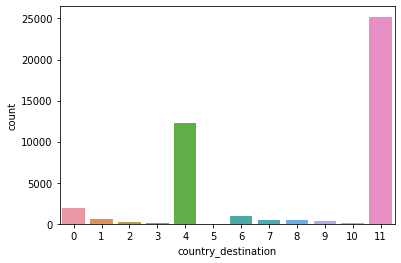

In [107]:
sns.countplot(val1.country_destination)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


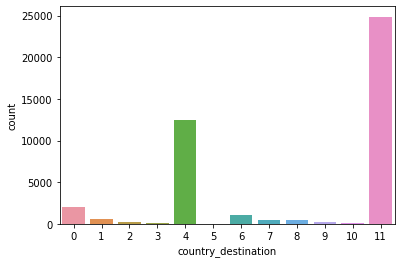

In [108]:
sns.countplot(val2.country_destination)

In [109]:
def ndcg(index):
  return 1/math.log2(index+2)

In [110]:
def cal_ndcg(preds,labels):
  size=len(labels)
  ndcg_score=0
  cnt=0
  for i in range(size):
    index=np.where(preds[i,:]==labels[i])[0]
    if len(index)==0:
      continue
    cnt+=1
    index=index[0]
    ndcg_score+=ndcg(index)
  return ndcg_score/size

In [111]:
country={'AU': 3, 'CA': 9, 'DE': 2, 'ES': 8, 'FR': 6, 'GB': 7, 'IT': 1, 'NDF': 11, 'NL': 10, 'PT': 5, 'US': 4, 'other': 0}
int_to_country={value:con for con,value in country.items()}

# Downsampling

In [112]:
def down_sampling(dataframe):
  dataframe_temp=dataframe[~dataframe.country_destination.isin([11,4])]
  dataframe_NDF=dataframe[dataframe.country_destination==11]
  dataframe_US=dataframe[dataframe.country_destination==4]
  subtrain_ndf=dataframe_NDF.sample(10000,random_state=42)
  subtrain_us=dataframe_US.sample(10000,random_state=42)
  data=pd.concat((dataframe_temp,subtrain_ndf,subtrain_us),axis=0)
  sns.countplot(data.country_destination)
  return data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


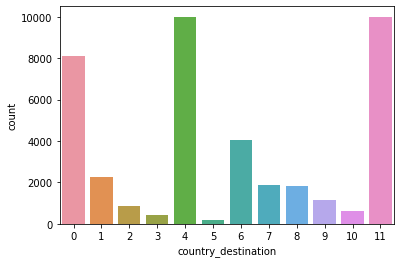

In [113]:
train_avg_sub=down_sampling(train1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


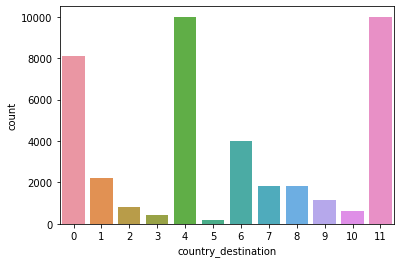

In [114]:
train_knn_sub=down_sampling(train2)

In [115]:
id_test=test1.id
test1.drop('id',axis=1,inplace=True)

In [116]:
test2.drop('id',axis=1,inplace=True)

In [117]:
def get_value(data_train,data_test,data_val):
  y_train=data_train.country_destination.values
  y_val=data_val.country_destination.values
  data_val.drop('country_destination',axis=1,inplace=True)
  data_train.drop('country_destination',axis=1,inplace=True)
  x_train=data_train.values
  x_test=data_test.values
  x_val=data_val.values
  return x_train,y_train,x_val,y_val,x_test

In [118]:
def submit(model,x_test,file_name):
  ids=[]
  cts=[]
  y_preds=model.predict_proba(x_test)
  for i in range(len(x_test)):
    idx=id_test[i]
    ids+=[idx]*5
    temp=np.argsort(y_preds[i])[::-1][:5].tolist()
    for value in temp:
      cts.append(int_to_country[value])
  sub=pd.DataFrame(np.column_stack((ids,cts)),columns=['id','country'])
  sub.to_csv(file_name,index=False)

In [119]:
lr=[0.005,0.01,0.05,0.1,0.15,0.2]

In [ ]:
!rm sub*
!rm lr*

1) Xgboost with avg_age

In [120]:
x_train1,y_train1,x_val1,y_val1,x_test1=get_value(train_avg_sub,test1.copy(),val1.copy())

In [121]:
def tuning_param(x_train,y_train,x_val,y_val,x_test,index,file_name):
  xgb=XGBClassifier(max_depth=10,learning_rate=lr[index],n_entimators=100,objective='multi:softprob',subsample=0.5,colsample_bytree=0.5,seed=43)
  xgb.fit(x_train,y_train)
  y_preds1=xgb.predict_proba(x_val)
  preds_down=np.argsort(y_preds1,axis=1)[:,-5:]
  preds_down=np.fliplr(preds_down)
  score=cal_ndcg(preds_down,y_val)
  submit(xgb,x_test,file_name+"_lr_"+str(lr[index])+'.csv')
  return score

In [122]:
def run(x_train,y_train,x_val,y_val,x_test,s):
  history_score=[]
  for i in range(len(lr)):
    score=tuning_param(x_train,y_train,x_val,y_val,x_test,i,'submmit_'+s)
    history_score.append(score)
    print(score)

  plt.plot(lr,history_score)
  plt.show()
  plt.savefig(f'lr_{s}.png')

0.7885386591320427
0.7872709484099271
0.7782334902458473
0.7664009923978942
0.7557469786008293
0.7466975159605366


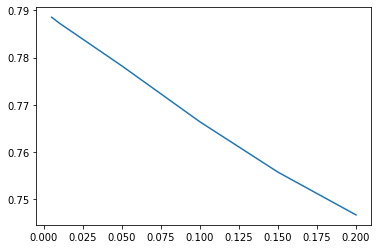

<Figure size 432x288 with 0 Axes>

In [123]:
run(x_train1,y_train1,x_val1,y_val1,x_test1,'avg')

2) knn age

In [124]:
x_train2,y_train2,x_val2,y_val2,x_test2=get_value(train_knn_sub,test2.copy(),val2.copy())

0.7865330708098152
0.7849522440395275
0.7758824685181545
0.7633833676486199
0.7523316005652906
0.7443413126340285


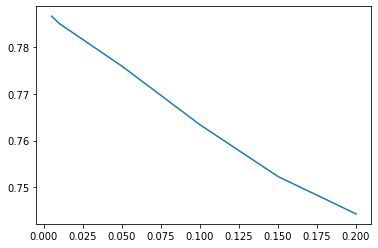

<Figure size 432x288 with 0 Axes>

In [125]:
run(x_train2,y_train2,x_val2,y_val2,x_test2,'knn')

# Data original

0.8232738249987241
0.8251862205951613
0.8283418920002229
0.8278229305993968
0.8271431257944282
0.8256797083292625


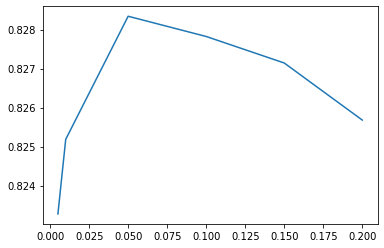

<Figure size 432x288 with 0 Axes>

In [127]:
x_train,y_train,x_val,y_val,x_test=get_value(train1.copy(),test1.copy(),val1.copy())
run(x_train,y_train,x_val,y_val,x_test,'avg_ori')

0.8188990363822678
0.821217115172219
0.8240916631648533
0.8243537237978218
0.8232612621806381
0.8215124119681628


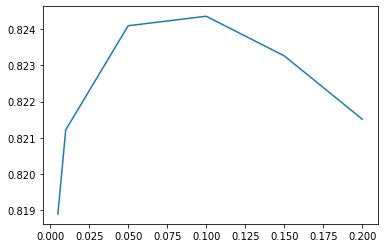

<Figure size 432x288 with 0 Axes>

In [128]:
x_train_k,y_train_k,x_val_k,y_val_k,x_test_k=get_value(train2.copy(),test2.copy(),val2.copy())
run(x_train_k,y_train_k,x_val_k,y_val_k,x_test_k,'knn_ori')